<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initializations" data-toc-modified-id="Initializations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initializations</a></span></li><li><span><a href="#Exact-Solution-for-Convection-Diffusion-Equation" data-toc-modified-id="Exact-Solution-for-Convection-Diffusion-Equation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exact Solution for Convection-Diffusion Equation</a></span></li><li><span><a href="#Discontinuous-Galerkin-Convection-Diffusion-with-upwind" data-toc-modified-id="Discontinuous-Galerkin-Convection-Diffusion-with-upwind-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Discontinuous Galerkin Convection-Diffusion with upwind</a></span></li><li><span><a href="#Hybrid-Discontinuous-Galerkin-Convection-Diffusion-with-upwind" data-toc-modified-id="Hybrid-Discontinuous-Galerkin-Convection-Diffusion-with-upwind-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hybrid Discontinuous Galerkin Convection-Diffusion with upwind</a></span></li><li><span><a href="#Solving-Mass-Matrix-problem" data-toc-modified-id="Solving-Mass-Matrix-problem-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Solving Mass Matrix problem</a></span></li><li><span><a href="#Enrichment" data-toc-modified-id="Enrichment-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Enrichment</a></span><ul class="toc-item"><li><span><a href="#Enrichment-for-Mass-Matrix" data-toc-modified-id="Enrichment-for-Mass-Matrix-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Enrichment for Mass Matrix</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Enrichment-for-Mass-Matrix-(enrich-x-axis)" data-toc-modified-id="Enrichment-for-Mass-Matrix-(enrich-x-axis)-6.1.0.1"><span class="toc-item-num">6.1.0.1&nbsp;&nbsp;</span>Enrichment for Mass Matrix (enrich x-axis)</a></span></li><li><span><a href="#Enrichment-for-Mass-Matrix-(enrich-y-axis)" data-toc-modified-id="Enrichment-for-Mass-Matrix-(enrich-y-axis)-6.1.0.2"><span class="toc-item-num">6.1.0.2&nbsp;&nbsp;</span>Enrichment for Mass Matrix (enrich y-axis)</a></span></li><li><span><a href="#Enrichment-for-Mass-Matrix-(enrich-both-xy-axis)" data-toc-modified-id="Enrichment-for-Mass-Matrix-(enrich-both-xy-axis)-6.1.0.3"><span class="toc-item-num">6.1.0.3&nbsp;&nbsp;</span>Enrichment for Mass Matrix (enrich both xy-axis)</a></span></li></ul></li></ul></li><li><span><a href="#Enrichment-with-DG" data-toc-modified-id="Enrichment-with-DG-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Enrichment with DG</a></span></li><li><span><a href="#Enrichment-with-HDG" data-toc-modified-id="Enrichment-with-HDG-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Enrichment with HDG</a></span></li></ul></li></ul></div>

In [2]:
import netgen.gui
from netgen.geom2d import unit_square
from ngsolve import *
import pandas as pd
from ngsolve import grad as oldgrad

ModuleNotFoundError: No module named 'netgen'

### Initializations

In [10]:
## Parameter setup
orders = [1, 2, 3, 4]
beta = (2,0.001)
mesh_size = [1.0, 0.5, 0.25, 0.1250, 0.0625]
#mesh_size = [0.0313]
eps = 0.01

# Exact Solution
#p = lambda x: x + (exp(beta[0]*x/eps)-1)/(1-exp(beta[0]/eps))
#q = lambda y: y + (exp(beta[1]*y/eps)-1)/(1-exp(beta[1]/eps))

p = lambda x: x + (exp(beta[0]*(x-1)/eps)-exp(-beta[0]/eps))/(exp(-beta[0]/eps)-1)
q = lambda y: y + (exp(beta[1]*(y-1)/eps)-exp(-beta[1]/eps))/(exp(-beta[1]/eps)-1)

exact = p(x) * q(y)

coeff =  beta[1] * p(x) +  beta[0] * q(y)

coeff_x = p(x)
coeff_y = q(y)

alpha = 10

## Dataframes
columns = ['Order', 'Mesh Size', 'Error', 'Type']

### Exact Solution for Convection-Diffusion Equation

In [7]:
orders = 2
mesh_size = 0.05
mesh = Mesh(unit_square.GenerateMesh(maxh=mesh_size))
fes = L2(mesh, order=orders, dirichlet="bottom|right|left|top")
gfu = GridFunction(fes)
Draw(exact, mesh, 'exact')

### Discontinuous Galerkin Convection-Diffusion with upwind

In [31]:
dg = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        fes = L2(mesh, order=order, dgjumps=True)
        u, v = fes.TnT()

        jump_u = u-u.Other()
        jump_v = v-v.Other()
        n = specialcf.normal(2)
        mean_dudn = 0.5 * n * (grad(u) + grad(u.Other()))
        mean_dvdn = 0.5 * n * (grad(v) + grad(v.Other()))

        h = specialcf.mesh_size

        # diffusion
        diffusion = grad(u) * grad(v) * dx \
            +alpha * order ** 2/ h * jump_u * jump_v * dx(skeleton=True) \
            +(-mean_dudn * jump_v - mean_dvdn * jump_u) * dx(skeleton=True) \
            +alpha * order ** 2/h * u * v * ds(skeleton=True) \
            + (-n * grad(u) * v -n * grad(v) * u) * ds(skeleton=True)

        # convection
        b = CoefficientFunction((beta[0],beta[1]) )
        uup = IfPos(b * n, u, u.Other())
        convection = -b * u * grad(v) * dx + b * n * uup * jump_v * dx(skeleton=True)
        
        acd = BilinearForm(fes)
        acd += eps * diffusion + convection
        acd.Assemble()
        
        # rhs
        f = LinearForm(fes)
        f += SymbolicLFI(coeff * v)
        f.Assemble()

        gfu = GridFunction(fes, name="uDG")  
        gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
        
        error = sqrt (Integrate ((gfu-exact)*(gfu-exact), mesh))
        dg.loc[len(dg)] = [order, size, error, 'dg']
        
        #Draw(gfu, mesh,"u",sd=5)
        #netgen.gui.Snapshot(w=800,h=500, filename='Images/' +"dg-h_"+str(size)+"-k_"+str(order)+".png")
        
        print ('Order:', order, 'Mesh Size:', size , "L2-error:", error)
    print('......................................................................')
    
#%store dg

Order: 1 Mesh Size: 1.0 L2-error: 0.006911642598847232
Order: 1 Mesh Size: 0.5 L2-error: 0.0018000469060358841
Order: 1 Mesh Size: 0.25 L2-error: 0.0006006000261945398
Order: 1 Mesh Size: 0.125 L2-error: 0.0009348420395054455
Order: 1 Mesh Size: 0.0625 L2-error: 0.0007738620274815043
......................................................................
Order: 2 Mesh Size: 1.0 L2-error: 0.0011926844012539468
Order: 2 Mesh Size: 0.5 L2-error: 0.001852028920520184
Order: 2 Mesh Size: 0.25 L2-error: 0.0015347676901403063
Order: 2 Mesh Size: 0.125 L2-error: 0.0008975232720150499
Order: 2 Mesh Size: 0.0625 L2-error: 0.00040365292237378385
......................................................................
Order: 3 Mesh Size: 1.0 L2-error: 0.002620446386549098
Order: 3 Mesh Size: 0.5 L2-error: 0.0031986518942105783
Order: 3 Mesh Size: 0.25 L2-error: 0.0012262237821181066
Order: 3 Mesh Size: 0.125 L2-error: 0.0005640031203681907
Order: 3 Mesh Size: 0.0625 L2-error: 0.00017996006639744728
.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pandas as pd
from functools import reduce
from IPython.display import Image, display
import matplotlib.image as mpimg


def plot_error(table):
    order_1 = table[table.Order.eq(1.0)]
    order_2 = table[table.Order.eq(2.0)]
    order_3 = table[table.Order.eq(3.0)]
    order_4 = table[table.Order.eq(4.0)]

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))

    order_1.plot(x='Mesh Size', y='Error', ax=ax1, legend=True, title='k = 1', style='.-', loglog=True)
    order_2.plot(x='Mesh Size', y='Error', ax=ax2, legend=True, title='k = 2', style='.-', loglog=True)
    order_3.plot(x='Mesh Size', y='Error', ax=ax3, legend=True, title='k = 3', style='.-', loglog=True)
    order_4.plot(x='Mesh Size', y='Error', ax=ax4, legend=True, title='k = 4', style='.-', loglog=True)

#plot_error(dg)

In [33]:
dg.to_csv('dg_60.csv')

### Hybrid Discontinuous Galerkin Convection-Diffusion with upwind

In [11]:
hdg = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order)
        F = FacetFESpace(mesh, order=order, dirichlet="bottom|left|right|top")

        fes = FESpace([V,F])
        u,uhat = fes.TrialFunction()
        v,vhat = fes.TestFunction()

        jump_u = u-uhat
        jump_v = v-vhat

        condense = True
        h = specialcf.mesh_size
        n = specialcf.normal(mesh.dim)

        dS = dx(element_boundary=True)

        # diffusion
        diffusion = grad(u) * grad(v) * dx + \
            alpha * order ** 2/h * jump_u * jump_v * dS + \
            (-grad(u) * n * jump_v - grad(v) * n * jump_u) * dS

        # convection            
        b = CoefficientFunction((beta[0],beta[1])) 
        uup = IfPos(b * n, u, uhat)
        convection = -b * u * grad(v) * dx + b * n * uup * jump_v * dS

        acd = BilinearForm(fes, condense=condense)
        acd += eps * diffusion + convection
        acd.Assemble()
        
        #rhs
        f = LinearForm(fes)
        f += SymbolicLFI(coeff * v)
        f.Assemble()

        gfu = GridFunction(fes)    
        if not condense:
            inv = acd.mat.Inverse(fes.FreeDofs(), "umfpack")
            gfu.vec.data = inv * f.vec
        else:
            f.vec.data += acd.harmonic_extension_trans * f.vec

            inv = acd.mat.Inverse(fes.FreeDofs(True), "umfpack")
            gfu.vec.data = inv * f.vec

            gfu.vec.data += acd.harmonic_extension * gfu.vec
            gfu.vec.data += acd.inner_solve * f.vec
            
        error = sqrt (Integrate ((gfu.components[0] - exact)*(gfu.components[0]- exact), mesh))
        hdg.loc[len(hdg)] = [order, size, error, 'hdg']
        
        # Draw(gfu.components[0], mesh,"u",sd=5)
        # netgen.gui.Snapshot(w=800,h=500, filename='Images/' + "hdg-h_"+str(size)+"-k_"+str(order)+".png")
        
        print ('Order:', order, 'Mesh Size:', size , "L2-error:", error)                            
    print('......................................................................')

%store hdg

Order: 1 Mesh Size: 1.0 L2-error: 0.0021388692850139966
Order: 1 Mesh Size: 0.5 L2-error: 0.0015448207320687085
Order: 1 Mesh Size: 0.25 L2-error: 0.000306667868916133
Order: 1 Mesh Size: 0.125 L2-error: 0.0002664203802452599
Order: 1 Mesh Size: 0.0625 L2-error: 0.00025697510865131673
......................................................................
Order: 2 Mesh Size: 1.0 L2-error: 0.0009453965788588372
Order: 2 Mesh Size: 0.5 L2-error: 0.0006825357593877055
Order: 2 Mesh Size: 0.25 L2-error: 0.0005863220096288398
Order: 2 Mesh Size: 0.125 L2-error: 0.0004040910540926051
Order: 2 Mesh Size: 0.0625 L2-error: 0.00022932110159325754
......................................................................
Order: 3 Mesh Size: 1.0 L2-error: 0.0008425809719983904
Order: 3 Mesh Size: 0.5 L2-error: 0.0008665829734104698
Order: 3 Mesh Size: 0.25 L2-error: 0.0006963995342044203
Order: 3 Mesh Size: 0.125 L2-error: 0.0003878141679165358
Order: 3 Mesh Size: 0.0625 L2-error: 0.0001362608919642922

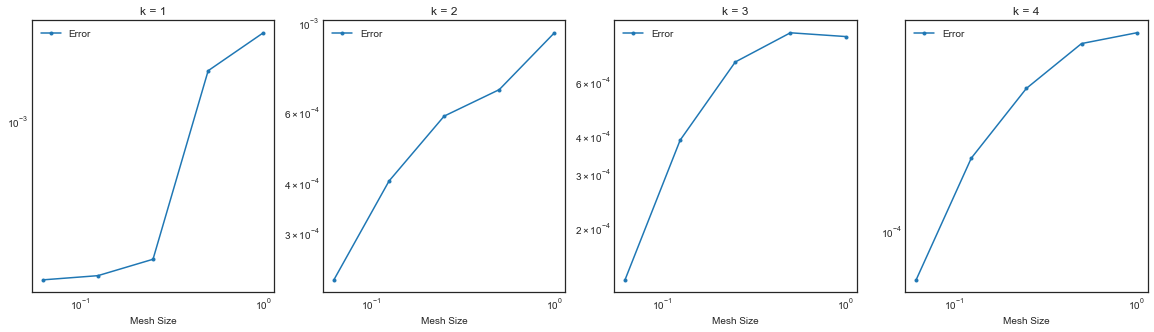

In [12]:
plot_error(hdg)
hdg.to_csv('hdg_5.csv')

### Solving Mass Matrix problem

In [18]:
mm = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        fes = L2(mesh, order=order, dirichlet="bottom|right|left|top")
        u, v = fes.TnT()
             
        m = BilinearForm(fes, symmetric=False)
        m += u * v * dx
        m.Assemble()
        
        f = LinearForm(fes)
        f += SymbolicLFI(exact * v)
        f.Assemble()
        
        invmstar = m.mat.Inverse(inverse="umfpack")
        
        gfu = GridFunction(fes)        
        gfu.vec.data = invmstar * f.vec
        
        error = sqrt (Integrate ((gfu-exact)*(gfu-exact), mesh))
        mm.loc[len(mm)] = [order, size, error] 
        
        Draw(gfu, mesh,"u",sd=5)
        netgen.gui.Snapshot(w=800,h=500, filename='Images/' + "mm-h_"+str(size)+"-k_"+str(order)+".png")
        
        print ('Order:', order, 'Mesh Size:', size , "L2-error:", error)            
    print('......................................................................')

%store mm

Order: 1 Mesh Size: 1.0 L2-error: 0.004459175075878796
Order: 1 Mesh Size: 0.5 L2-error: 0.00276080549360834
Order: 1 Mesh Size: 0.25 L2-error: 0.0015611084025224855
Order: 1 Mesh Size: 0.125 L2-error: 0.0009505531270130825
Order: 1 Mesh Size: 0.0625 L2-error: 0.0005425383964925907
Order: 1 Mesh Size: 0.0313 L2-error: 0.0002718806091670007
......................................................................
Order: 2 Mesh Size: 1.0 L2-error: 0.000520829059102421
Order: 2 Mesh Size: 0.5 L2-error: 0.00011315394599981354
Order: 2 Mesh Size: 0.25 L2-error: 0.00012161280758327406
Order: 2 Mesh Size: 0.125 L2-error: 0.00018388342675309724
Order: 2 Mesh Size: 0.0625 L2-error: 0.00013790607359845654
Order: 2 Mesh Size: 0.0313 L2-error: 5.835771499725604e-05
......................................................................
Order: 3 Mesh Size: 1.0 L2-error: 1.4432766278165542e-06
Order: 3 Mesh Size: 0.5 L2-error: 1.6053585394211418e-06
Order: 3 Mesh Size: 0.25 L2-error: 1.7700643967471053e

### Enrichment

#### Enrichment for Mass Matrix

###### Enrichment for Mass Matrix (enrich x-axis)

In [22]:
emm_x = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        eps_size = size
        #eps = 1e-8
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order, dirichlet="bottom|right|left|top")
        Q = L2(mesh, order=0)
        
        ba_x = BitArray(Q.ndof)        
        ba_x.Clear()
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[0] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_x[dof] = mark
        
        Qx = Compress(Q, active_dofs=ba_x)
        fes = FESpace([V, Qx])
        (us, px), (vs, qx) = fes.TnT()
        
        p = coeff_x * px
        q = coeff_x * qx

        u = us + p
        v = vs + q

        m = BilinearForm(fes, symmetric=False)
        m += SymbolicBFI(u * v).SetIntegrationRule(TRIG,IntegrationRule(TRIG,10*order))
        m.Assemble()

        f = LinearForm(fes)
        f += SymbolicLFI(exact * v).SetIntegrationRule(TRIG,IntegrationRule(TRIG,4*order))
        f.Assemble()

        invmstar = m.mat.Inverse(inverse="sparsecholesky")
        
        gfu = GridFunction(fes)
        gfu.vec.data = invmstar * f.vec
        
        u2 = gfu.components[0] + gfu.components[1] * coeff_x
        
        error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh))
        emm_x.loc[len(emm_x)] = [order, size, error] 
        
        Draw(u2, mesh,"u",sd=5)
        netgen.gui.Snapshot(w=800,h=500, filename='Images/' + "mmx-h_"+str(size)+"-k_"+str(order)+".png")
        
        print('Order:', order, ' Mesh Size:', size , "L2 Error:", error)
    print('...........................................................')
    

%store emm_x

Order: 1  Mesh Size: 1.0 L2 Error: 0.002952636918040936
Order: 1  Mesh Size: 0.5 L2 Error: 0.0009501798785034101
Order: 1  Mesh Size: 0.25 L2 Error: 0.00043207219306410017
Order: 1  Mesh Size: 0.125 L2 Error: 0.00016864186418859539
Order: 1  Mesh Size: 0.0625 L2 Error: 0.00016128397515625427
Order: 1  Mesh Size: 0.0313 L2 Error: 6.772025556227388e-05
...........................................................
Order: 2  Mesh Size: 1.0 L2 Error: 0.001118191394806087
Order: 2  Mesh Size: 0.5 L2 Error: 0.00026975255465462193
Order: 2  Mesh Size: 0.25 L2 Error: 5.1198173308916446e-05
Order: 2  Mesh Size: 0.125 L2 Error: 2.7204401671671377e-05
Order: 2  Mesh Size: 0.0625 L2 Error: 1.1572495937445686e-05
Order: 2  Mesh Size: 0.0313 L2 Error: 2.210127347266843e-06
...........................................................
Order: 3  Mesh Size: 1.0 L2 Error: 0.0005307327802862197
Order: 3  Mesh Size: 0.5 L2 Error: 7.076022323416959e-05
Order: 3  Mesh Size: 0.25 L2 Error: 6.15217373476984e-05
Or

###### Enrichment for Mass Matrix (enrich y-axis)

In [23]:
emm_y = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        eps_size = size
        #eps = 1e-8
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order, dirichlet="bottom|right|left|top")
        Q = L2(mesh, order=0)
        
        ba_y = BitArray(Q.ndof)        
        ba_y.Clear()
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[1] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_y[dof] = mark
        
        Qy = Compress(Q, active_dofs=ba_y)
        fes = FESpace([V, Qy])
        (us, py), (vs, qy) = fes.TnT()
        
        p = coeff_y * py
        q = coeff_y * qy

        u = us + p
        v = vs + q

        m = BilinearForm(fes, symmetric=False)
        m += SymbolicBFI(u * v).SetIntegrationRule(TRIG,IntegrationRule(TRIG,10*order))
        m.Assemble()

        f = LinearForm(fes)
        f += SymbolicLFI(exact * v).SetIntegrationRule(TRIG,IntegrationRule(TRIG,4*order))
        f.Assemble()

        invmstar = m.mat.Inverse(inverse="sparsecholesky")
        
        gfu = GridFunction(fes)
        gfu.vec.data = invmstar * f.vec
        
        u2 = gfu.components[0] + gfu.components[1] * coeff_y
        
        error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh))
        emm_y.loc[len(emm_y)] = [order, size, error] 
        
        Draw(u2, mesh,"u",sd=5)
        netgen.gui.Snapshot(w=800,h=500, filename='Images/' + "mmy-h_"+str(size)+"-k_"+str(order)+".png")
        
        print('Order:', order, ' Mesh Size:', size , "L2 Error:", error)
    print('...........................................................')
    
%store emm_y

Order: 1  Mesh Size: 1.0 L2 Error: 0.0008768977915884472
Order: 1  Mesh Size: 0.5 L2 Error: 0.0002833798014764053
Order: 1  Mesh Size: 0.25 L2 Error: 0.0001587711632443963
Order: 1  Mesh Size: 0.125 L2 Error: 0.00022733105121315887
Order: 1  Mesh Size: 0.0625 L2 Error: 0.00023019651366120643
Order: 1  Mesh Size: 0.0313 L2 Error: 0.00015173522664498626
...........................................................
Order: 2  Mesh Size: 1.0 L2 Error: 0.0003436446994244419
Order: 2  Mesh Size: 0.5 L2 Error: 0.00012668855441226573
Order: 2  Mesh Size: 0.25 L2 Error: 0.00013551816372671095
Order: 2  Mesh Size: 0.125 L2 Error: 0.00011937240345172871
Order: 2  Mesh Size: 0.0625 L2 Error: 0.00010532969884170173
Order: 2  Mesh Size: 0.0313 L2 Error: 5.157608314558916e-05
...........................................................
Order: 3  Mesh Size: 1.0 L2 Error: 2.067290006840831e-05
Order: 3  Mesh Size: 0.5 L2 Error: 0.0001780025296640239
Order: 3  Mesh Size: 0.25 L2 Error: 0.0002142393444698333

###### Enrichment for Mass Matrix (enrich both xy-axis)

In [21]:
emm_xy = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        eps_size = size
        #eps = 1e-8
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order, dirichlet="bottom|right|left|top")
        Q = L2(mesh, order=0)
        
        ba_x = BitArray(Q.ndof)        
        ba_x.Clear()
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[0] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_x[dof] = mark
        
        ba_y = BitArray(Q.ndof)        
        ba_y.Clear()
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[1] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_y[dof] = mark
        
        Qx = Compress(Q, active_dofs=ba_x)
        Qy = Compress(Q, active_dofs=ba_y)
        
        fes = FESpace([V, Qx, Qy])

        (us, px, py), (vs, qx, qy) = fes.TnT()
        
        #coeff=exact
        p = coeff_x * px + coeff_y * py
        q = coeff_x * qx + coeff_y * qy

        u = us + p
        v = vs + q

        m = BilinearForm(fes, symmetric=False)
        m += SymbolicBFI(u * v).SetIntegrationRule(TRIG,IntegrationRule(TRIG,10*order))
        m.Assemble()

        f = LinearForm(fes)
        f += SymbolicLFI(exact * v).SetIntegrationRule(TRIG,IntegrationRule(TRIG,4*order))
        f.Assemble()

        invmstar = m.mat.Inverse(inverse="sparsecholesky")
        
        gfu = GridFunction(fes)
        gfu.vec.data = invmstar * f.vec
        
        u2 = gfu.components[0] + gfu.components[1] * coeff_x + gfu.components[2] * coeff_y
        #Draw(u2-exact,mesh, 'error')
        #Draw(gfu.components[0], mesh, 'testa')
        #Draw(gfu.components[1], mesh, 'testb')
        #Draw(gfu.components[1] * coeff, mesh, 'testc')
        error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh))
        emm_xy.loc[len(emm_xy)] = [order, size, error] 
        
        Draw(u2, mesh,"u",sd=5)
        netgen.gui.Snapshot(w=800,h=500, filename='Images/' + "mmxy-h_"+str(size)+"-k_"+str(order)+".png")
        
        print('Order:', order, ' Mesh Size:', size , "L2 Error:", error)
    print('...........................................................')
    
Draw(u2, mesh, 'test')
%store emm_xy

Order: 1  Mesh Size: 1.0 L2 Error: 0.0024882388345344526
Order: 1  Mesh Size: 0.5 L2 Error: nan
Order: 1  Mesh Size: 0.25 L2 Error: 0.0004317936237340082
Order: 1  Mesh Size: 0.125 L2 Error: 0.00016869467161744953
Order: 1  Mesh Size: 0.0625 L2 Error: 0.00016123919512957377
Order: 1  Mesh Size: 0.0313 L2 Error: 6.77108905719306e-05
...........................................................
Order: 2  Mesh Size: 1.0 L2 Error: 0.0010660990044307854
Order: 2  Mesh Size: 0.5 L2 Error: 0.00027173411064722016
Order: 2  Mesh Size: 0.25 L2 Error: 5.168195966095573e-05
Order: 2  Mesh Size: 0.125 L2 Error: 2.719436874514838e-05
Order: 2  Mesh Size: 0.0625 L2 Error: 1.1523078251078182e-05
Order: 2  Mesh Size: 0.0313 L2 Error: 2.184692199963132e-06
...........................................................
Order: 3  Mesh Size: 1.0 L2 Error: 0.000535077074655014
Order: 3  Mesh Size: 0.5 L2 Error: 7.11747459566518e-05
Order: 3  Mesh Size: 0.25 L2 Error: 6.190525038952954e-05
Order: 3  Mesh Size: 0.

In [47]:
## Observations
# Emriching the y axis has a better convergence rate then enriching both x and y
# umfpack fails for this problem

#### Enrichment with DG

In [9]:
edg = pd.DataFrame(columns=columns)
val = 15 # bonusintorder
for order in orders:
    for size in mesh_size:
        eps_size = size / 2
        #eps = 1e-8
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order, dgjumps=True)
        Q = L2(mesh, order=0)
        
        ba_x = BitArray(Q.ndof)        
        ba_x.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[0] > 1- eps_size):
                    mark = True
            for dof in el.dofs:
                ba_x[dof] = mark
        
        ba_y = BitArray(Q.ndof)
        ba_y.Clear()
        
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[1] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_y[dof] = mark
        
        Qx = Compress(Q, active_dofs=ba_x)
        Qy = Compress(Q, active_dofs=ba_y)
        
        fes = FESpace([V, Qx, Qy], dgjumps = True)

        (us, px, py), (vs, qx, qy) = fes.TnT()
        
        #coeff=exact
        ## Enrichment
        p = (coeff_x * px) + (coeff_y * py)
        q = (coeff_x * qx) + (coeff_y * qy)

        u = us + p
        v = vs + q
        
        u_Other = us.Other() + coeff_x * px.Other() + coeff_y * py.Other()
        v_Other = vs.Other() + coeff_x * qx.Other() + coeff_y * qy.Other()
        
        jump_u = u - u_Other
        jump_v = v - v_Other
        
        n = specialcf.normal(2)
        
        grad_u = grad(us) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py \
        + coeff_x * grad(px) + coeff_y * grad(py)
        
        grad_v = grad(vs) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy \
        + coeff_x * grad(qx) + coeff_y * grad(qy)
        
        grad_uOther = grad(us.Other()) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px.Other() \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py.Other() \
        + coeff_x * grad(px.Other()) + coeff_y * grad(py.Other())
        
        grad_vOther = grad(vs.Other()) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx.Other() \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy.Other() \
        + coeff_x * grad(qx.Other()) + coeff_y * grad(qy.Other())
                
            
        mean_dudn = 0.5 * n * (grad_u + grad_uOther)
        mean_dvdn = 0.5 * n * (grad_v + grad_vOther)
        
        h = specialcf.mesh_size
        
        # diffusion
        diffusion = grad_u * grad_v * dx(bonus_intorder = val) \
        + alpha * order**2/h * jump_u * jump_v * dx(skeleton=True, bonus_intorder = val) \
        + (-mean_dudn* jump_v - mean_dvdn * jump_u) * dx(skeleton=True, bonus_intorder = val) \
        + alpha * order**2/h * u * v * ds(skeleton=True, bonus_intorder = val) \
        + (-n * grad_u * v - n * grad_v * u) * ds(skeleton=True, bonus_intorder = val)
                
        # convection
        b = CoefficientFunction((beta[0],beta[1]) )
        uup = IfPos(b*n, u, u_Other)
        convection = -b * u * grad_v * dx(bonus_intorder = val) + b * n * uup * jump_v * dx(skeleton=True, bonus_intorder = val)
        convection = -b * u * grad_v * dx(bonus_intorder = val) + b * n * uup * v * dx(element_boundary=True, bonus_intorder = val)
       
        acd = BilinearForm(fes)
        acd += eps * diffusion #+ convection
        #acd += convection
        
        with TaskManager():
            acd.Assemble()

        # rhs
        f = LinearForm(fes)
        f += SymbolicLFI(coeff * v, bonus_intorder = val)
        
        with TaskManager():
            f.Assemble()

        gfu = GridFunction(fes)
        gfu.vec.data = acd.mat.Inverse(inverse="umfpack") * f.vec
    
        u2 = gfu.components[0] + gfu.components[1] * coeff_x + gfu.components[2] * coeff_y
        
        error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh))
        edg.loc[len(edg)] = [order, size, error]
        
        Draw(u2,mesh,"u",sd=5)
        #netgen.gui.Snapshot(w=800,h=500, filename='Images/' + "edg-h_"+str(size)+"-k_"+str(order)+".png")
        
        print('Order:', order, ' Mesh Size:', size , "L2 Error:", error)
    print('.......................................................................')
        
%store edg

Order: 1  Mesh Size: 0.0313 L2 Error: 0.08120156881207805
.......................................................................
Stored 'edg' (DataFrame)


#### Enrichment with HDG

In [4]:
ehdg = pd.DataFrame(columns=columns)
val = 15
for order in orders:
    for size in mesh_size:        
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order)
        Q = L2(mesh, order=0)
        QF = FacetFESpace(mesh, order=0)
        
        eps_size = 0.0001*size
        
        ba_x = BitArray(Q.ndof)        
        ba_x.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[0] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_x[dof] = mark
        
        ba_y = BitArray(Q.ndof)
        ba_y.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[1] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_y[dof] = mark
        
        
        gfF = GridFunction(QF)
        
        gfF.vec[:] = 0
        for el in QF.Elements():
            if ba_x[el.nr]:
                for dof in el.dofs:
                    gfF.vec[dof] += 1
        ba_F_x = BitArray(QF.ndof)
        ba_F_x.Clear()
        for i in range(QF.ndof):
            if gfF.vec[i] > 1.5:
                ba_F_x[i] = True

        gfF.vec[:] = 0
        for el in QF.Elements():
            if ba_y[el.nr]:
                for dof in el.dofs:
                    gfF.vec[dof] += 1
        ba_F_y = BitArray(QF.ndof)
        ba_F_y.Clear()
        for i in range(QF.ndof):
            if gfF.vec[i] > 1.5:
                ba_F_y[i] = True
        
        Qx = Compress(Q, active_dofs=ba_x)
        Qy = Compress(Q, active_dofs=ba_y)
        QFx = Compress(QF, active_dofs=ba_F_x)
        QFy = Compress(QF, active_dofs=ba_F_y)
        
        F = FacetFESpace(mesh, order=order, dirichlet=".*")
        fes = FESpace([V, Qx, Qy, F, QFx, QFy])

        (us, px, py, uhat, uhatx, uhaty), (vs, qx, qy, vhat, vhatx, vhaty) = fes.TnT()
        
        #coeff=exact
        p = (coeff_x * px) + (coeff_y * py) 
        q = (coeff_x * qx) + (coeff_y * qy)

        u = us + p
        v = vs + q
        
        vhat = vhat + vhatx * coeff_x + vhaty * coeff_y
        uhat = uhat + uhatx * coeff_x + uhaty * coeff_y
        
        jump_u = u-uhat
        jump_v = v-vhat
        
        grad_u = grad(us) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py \
        + coeff_x * grad(px) + coeff_y * grad(py)
        
        grad_v = grad(vs) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy \
        + coeff_x * grad(qx) + coeff_y * grad(qy)
        
        #condense = True
        
        h = specialcf.mesh_size
        n = specialcf.normal(mesh.dim)
        dS = dx(element_boundary=True, bonus_intorder=val)
                
        diffusion = grad_u * grad_v *dx(bonus_intorder=val) + \
            alpha * order**2/h*jump_u*jump_v*dS + \
            (-grad_u *n*jump_v - grad_v *n*jump_u)*dS
        
        b = CoefficientFunction((beta[0],beta[1]))
        uup = IfPos(b * n, u, uhat)
        convection = -b * u * grad_v *dx(bonus_intorder=val) + b * n * uup * jump_v * dS

        acd = BilinearForm(fes)
        acd += eps * diffusion + convection
        
        with TaskManager():
            acd.Assemble()

        f = LinearForm(fes)
        f += SymbolicLFI(coeff*v,bonus_intorder=val)
        
        with TaskManager():
            f.Assemble()

        gfu = GridFunction(fes)
        gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
        u2 = gfu.components[0] + gfu.components[1] * coeff_x + gfu.components[2] * coeff_y
        
        error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh, order=15))
        ehdg.loc[len(ehdg)] = [order, size, error] 
        
        #Draw(u2,mesh,"u",sd=5)
        #netgen.gui.Snapshot(w=800,h=500, filename='Images/' + "ehdg-h_"+str(size)+"-k_"+str(order)+".png")
        
        print('Order:', order, ' Mesh Size:', size , "L2 Error:", error)
    print('.......................................................................')

%store ehdg    

Order: 1  Mesh Size: 1.0 L2 Error: 0.0010603215665766072
Order: 1  Mesh Size: 0.5 L2 Error: 0.0004311254252274262
Order: 1  Mesh Size: 0.25 L2 Error: 0.00016563984009721885
Order: 1  Mesh Size: 0.125 L2 Error: 6.383975239122373e-05
Order: 1  Mesh Size: 0.0625 L2 Error: 2.392633110794041e-05
Order: 1  Mesh Size: 0.0313 L2 Error: 8.03240600944079e-06
.......................................................................
Stored 'ehdg' (DataFrame)
